# **Application of machine learning for forecasting 3-month interest rate (3MUSD=) and USD FX level in Python**
Youssef Louraoui (20230348@etud.univ-evry.fr)

## **Preparation of the Working Environment on Python**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
FX_data = pd.read_excel("/Volumes/T7 1TB SSD/Empirical_Analysis_FM/Applied_Research_Framework_Git/Applied_projects/ML_applications/ML_forecasting_IRUSD/Data.xlsx", sheet_name="FX_extraction", skiprows=1)
Rates_data = pd.read_excel("/Volumes/T7 1TB SSD/Empirical_Analysis_FM/Applied_Research_Framework_Git/Applied_projects/ML_applications/ML_forecasting_IRUSD/Data.xlsx", sheet_name="Rates_extraction", skiprows=1)
print(FX_data)
print(Rates_data)

     Unnamed: 0  GBP3MD=  EUR3MD=  USD3MD=  NOK3MD=  JPY3MD=  CHF3MD=  \
0    2014-01-01     0.45     0.20     0.16     1.54    -0.04    -0.10   
1    2014-01-02     0.45     0.20     0.19     1.54     0.01    -0.05   
2    2014-01-03     0.47     0.20     0.20     1.55     0.05    -0.10   
3    2014-01-06     0.48     0.20     0.21     1.53     0.01    -0.10   
4    2014-01-07     0.46     0.19     0.24     1.53     0.05    -0.10   
...         ...      ...      ...      ...      ...      ...      ...   
2632 2023-12-26     5.27     3.95     5.44     4.52    -0.51     1.58   
2633 2023-12-27     5.20     3.86     5.35     4.47    -0.55     1.58   
2634 2023-12-28     5.23     3.95     5.33     4.56    -0.30     1.44   
2635 2023-12-29     5.22     3.88     5.31     4.52    -0.28     1.58   
2636 2024-01-01     5.21     3.92     5.43     4.51    -0.28     1.58   

      AUD3MD=  NZD3MD=  CAD3MD=  SEK3MD=  
0        2.55     2.70     0.92     0.82  
1        2.56     2.82     1.07     0

In [51]:
# Rename the first column to 'Date' in both dataframes
FX_data.rename(columns={FX_data.columns[0]: 'Date'}, inplace=True)
Rates_data.rename(columns={Rates_data.columns[0]: 'Date'}, inplace=True)

# We convert the 'Date' columns to datetime
FX_data['Date'] = pd.to_datetime(FX_data['Date'])
Rates_data['Date'] = pd.to_datetime(Rates_data['Date'])

# First merge: Merge FX_data and Rates_data on 'Date'
merged_df = pd.merge(FX_data, Rates_data, on='Date', how='outer')

# Removing rows with any NA values
merged_df.dropna(inplace=True)

# Ensuring all columns except 'Date' are numeric
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# We set the 'Date' column as the index
merged_df.set_index('Date', inplace=True)

In [52]:
# Eliminate the columns that will not be used
columns_to_remove = ['Date','USD3MD=']
predictor_columns = [col for col in merged_df.columns if col not in columns_to_remove]

# Isolate the forecasted data into a separate DataFrame
df_variables = merged_df[predictor_columns]
df_USD3M = merged_df[['USD3MD=']].copy()
df_USDfx = merged_df[['=USD']].copy()

# Have a look at the different variables that are used as predictors for the analysis
print(df_variables.info())
print(df_variables.describe())
print(df_variables.head())
print(df_USD3M.head())
print(df_USDfx.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-01-02 to 2024-01-01
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GBP3MD=  2608 non-null   float64
 1   EUR3MD=  2608 non-null   float64
 2   NOK3MD=  2608 non-null   float64
 3   JPY3MD=  2608 non-null   float64
 4   CHF3MD=  2608 non-null   float64
 5   AUD3MD=  2608 non-null   float64
 6   NZD3MD=  2608 non-null   float64
 7   CAD3MD=  2608 non-null   float64
 8   SEK3MD=  2608 non-null   float64
 9   GBP=     2608 non-null   float64
 10  EUR=     2608 non-null   float64
 11  =USD     2608 non-null   float64
 12  NOK=     2608 non-null   float64
 13  JPY=     2608 non-null   float64
 14  CHF=     2608 non-null   float64
 15  AUD=     2608 non-null   float64
 16  NZD=     2608 non-null   float64
 17  CAD=     2608 non-null   float64
 18  SEK=     2608 non-null   float64
dtypes: float64(19)
memory usage: 407.5 KB
None
           GBP3MD=      EUR3M

In [53]:
# Analysis of the data from the 3-month interest rate patterns
print(df_USD3M.info())
print(df_USD3M.describe())
print(df_USD3M.head())

# Calculate returns for the predictors
arith_returns = df_variables.pct_change().dropna()

# Analysis of the statistical performance of the 3-month interest rate loading
print(df_USD3M['USD3MD='].pct_change().dropna().head())
print(df_USD3M['USD3MD='].pct_change().dropna().describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-01-02 to 2024-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD3MD=  2608 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB
None
           USD3MD=
count  2608.000000
mean      1.534456
std       1.612131
min       0.050000
25%       0.230000
50%       0.960000
75%       2.290000
max       5.740000
            USD3MD=
Date               
2014-01-02     0.19
2014-01-03     0.20
2014-01-06     0.21
2014-01-07     0.24
2014-01-08     0.17
Date
2014-01-03    0.052632
2014-01-06    0.050000
2014-01-07    0.142857
2014-01-08   -0.291667
2014-01-09   -0.058824
Name: USD3MD=, dtype: float64
count    2607.000000
mean        0.020883
std         0.250490
min        -0.812500
25%        -0.003636
50%         0.000000
75%         0.007775
max         4.333333
Name: USD3MD=, dtype: float64


In [54]:
from scipy import stats
# Standardize the data
df_variables_standardized = (df_variables - df_variables.mean()) / df_variables.std()

# Remove outliers beyond 3 standard deviations
df_variables_zscore = df_variables_standardized[(np.abs(stats.zscore(df_variables_standardized)) < 3).all(axis=1)]

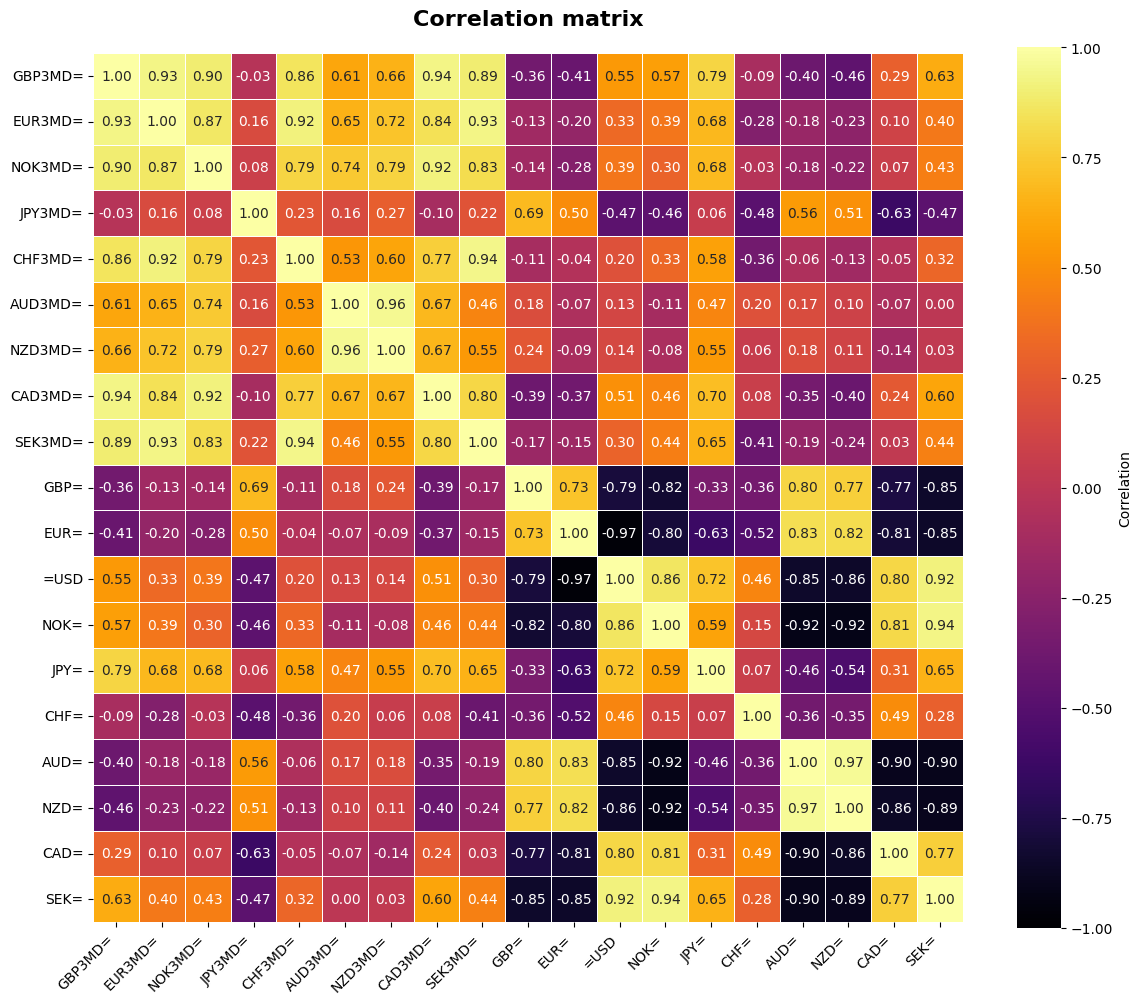

In [55]:
import seaborn as sns

correlation_matrix = df_variables_zscore.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, 
            cmap='inferno',
            vmin=-1, 
            vmax=1,
            center=0,
            square=True, 
            linewidths=0.5,
            annot=True, 
            fmt=".2f",
            cbar_kws={"label": "Correlation"})

plt.title('Correlation matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


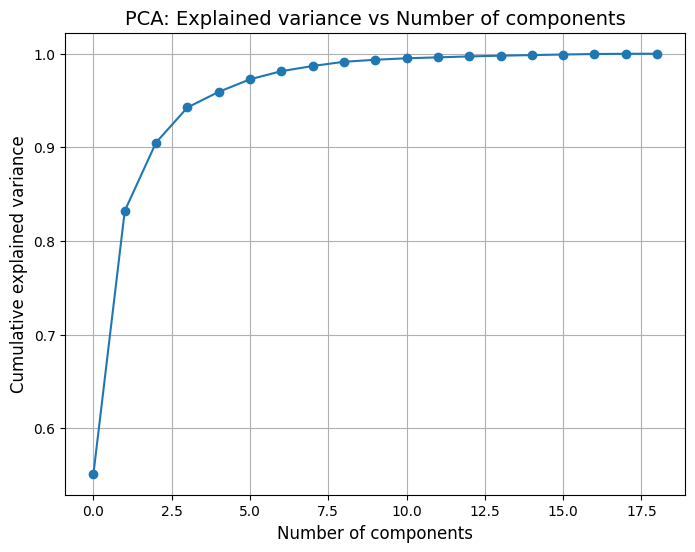

Explained variance ratio per component:
PC1: 0.5516
PC2: 0.2807
PC3: 0.0729
PC4: 0.0374
PC5: 0.0167
PC6: 0.0134
PC7: 0.0087
PC8: 0.0055
PC9: 0.0045
PC10: 0.0022
PC11: 0.0015
PC12: 0.0010
PC13: 0.0010
PC14: 0.0008
PC15: 0.0007
PC16: 0.0006
PC17: 0.0005
PC18: 0.0003
PC19: 0.0001

Number of components explaining at least 95% variance: 5
New shape for ML input: (2608, 5)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_variables)

# Run PCA (fit all components to visualize explained variance)
pca = PCA(n_components=19)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)
plt.title('PCA: Explained variance vs Number of components', fontsize=14)
plt.grid(True)
plt.show()

# Print out explained variance ratio for each component
print("Explained variance ratio per component:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var_ratio:.4f}")

# Choose number of components to retain (e.g., enough to explain >=95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\nNumber of components explaining at least 95% variance: {n_components}")

# Re-fit and transform with selected number of components for your ML model
pca_final = PCA(n_components=n_components)
X_reduced = pca_final.fit_transform(X_scaled)

# X_reduced can now be used as input for your ML models with much lower risk of overfitting
print(f"New shape for ML input: {X_reduced.shape}")

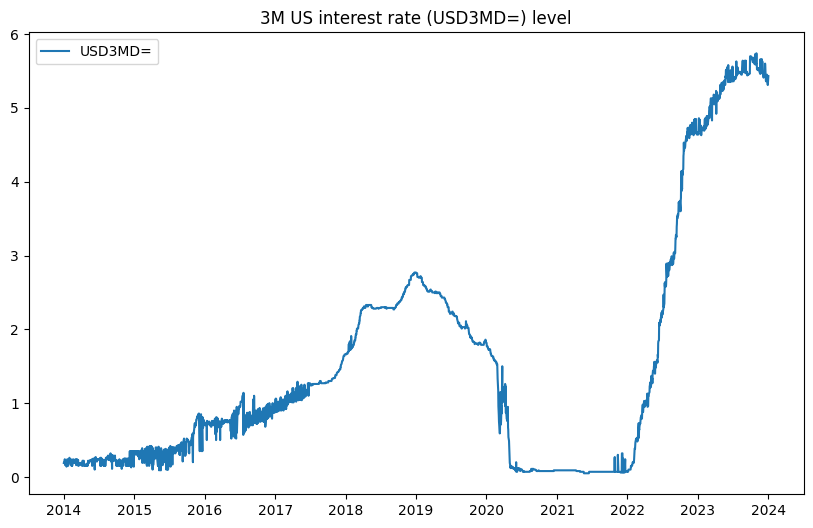

In [57]:
# Plot the 3M US interest rate time series

plt.figure(figsize=(10, 6))
plt.plot(df_USD3M['USD3MD='], label='USD3MD=')
plt.title('3M US interest rate (USD3MD=) level')
plt.legend()
plt.show()

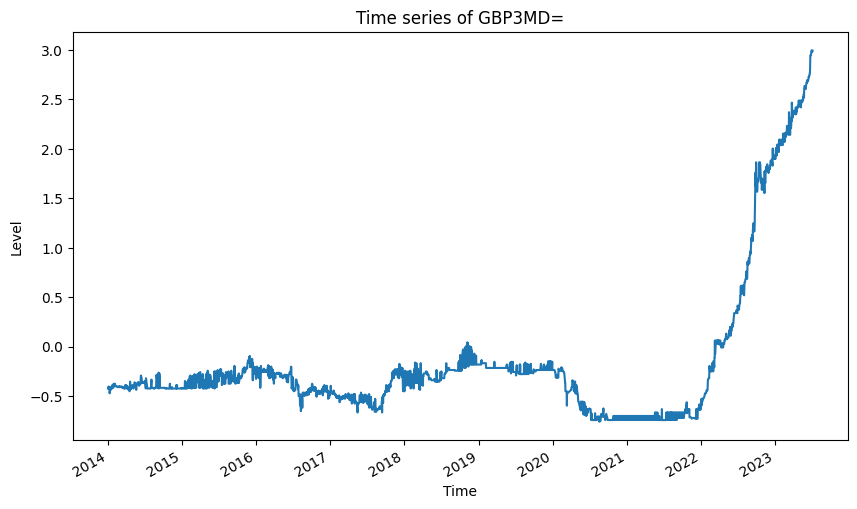

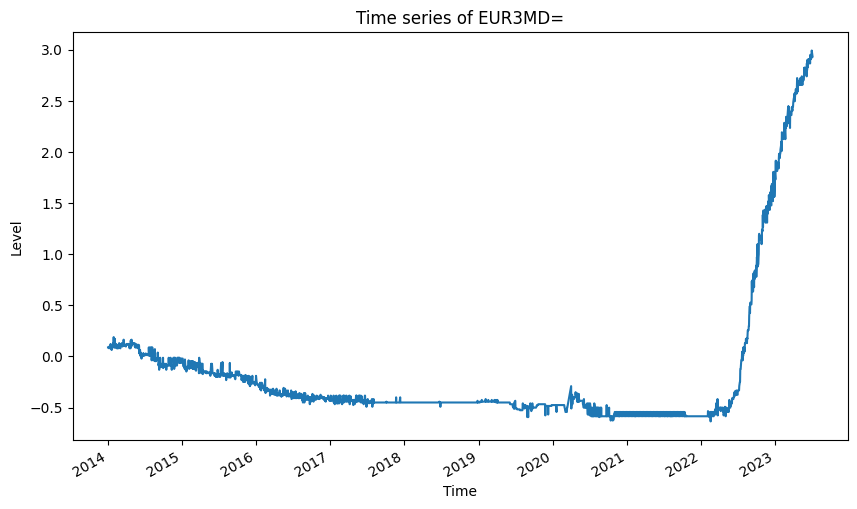

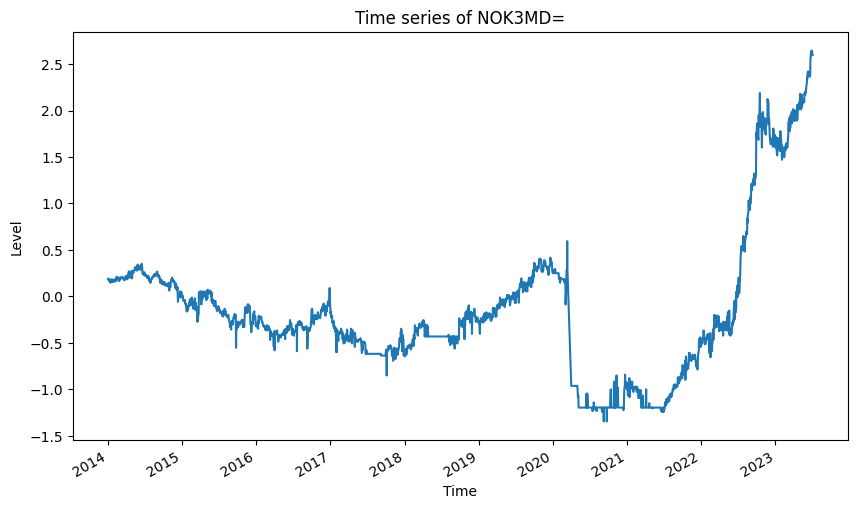

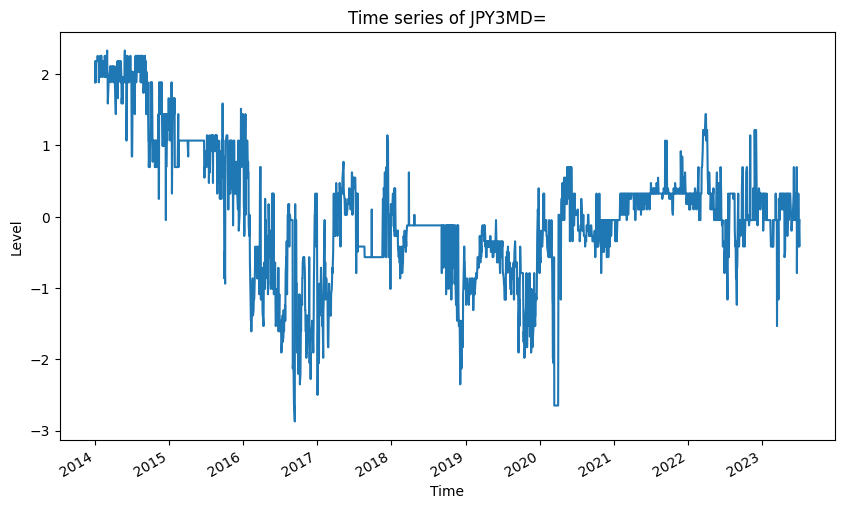

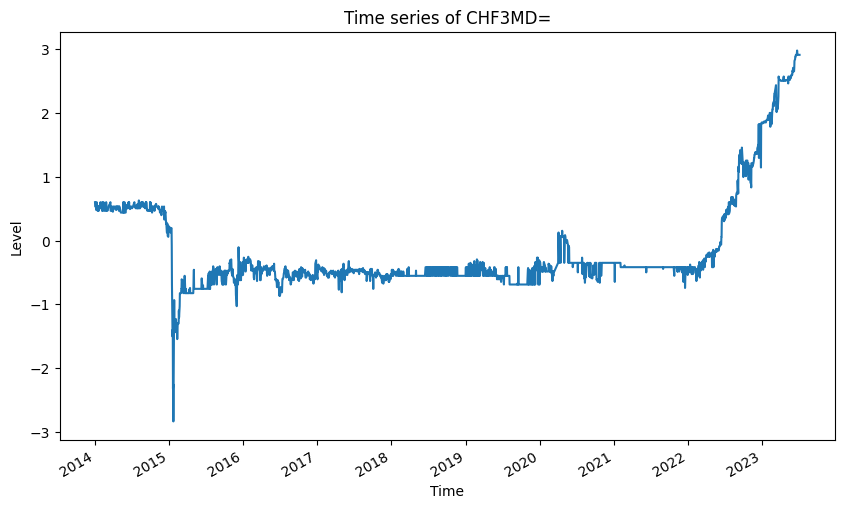

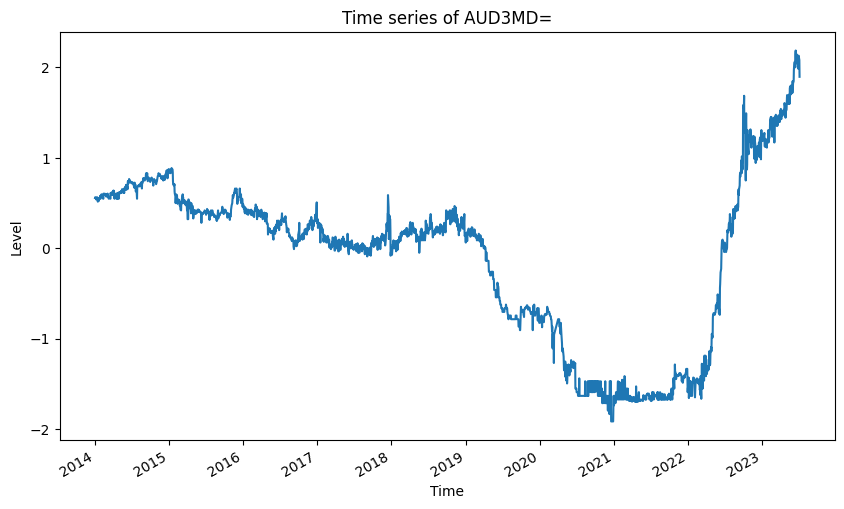

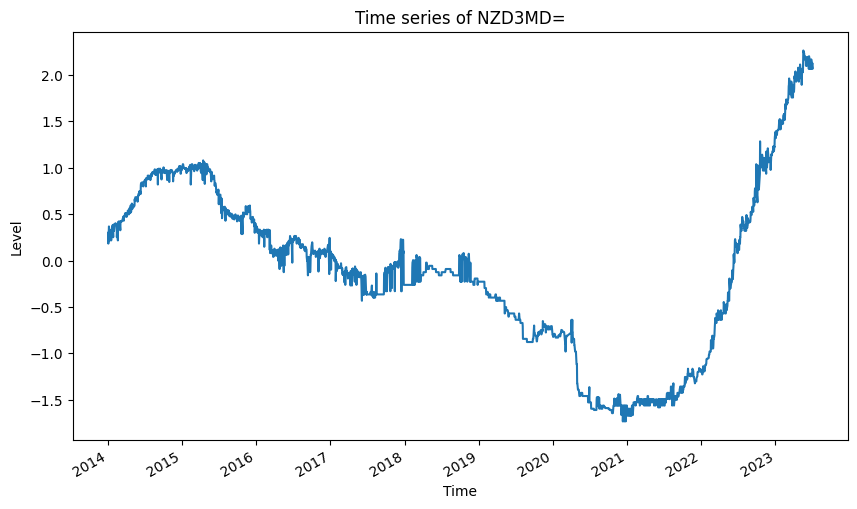

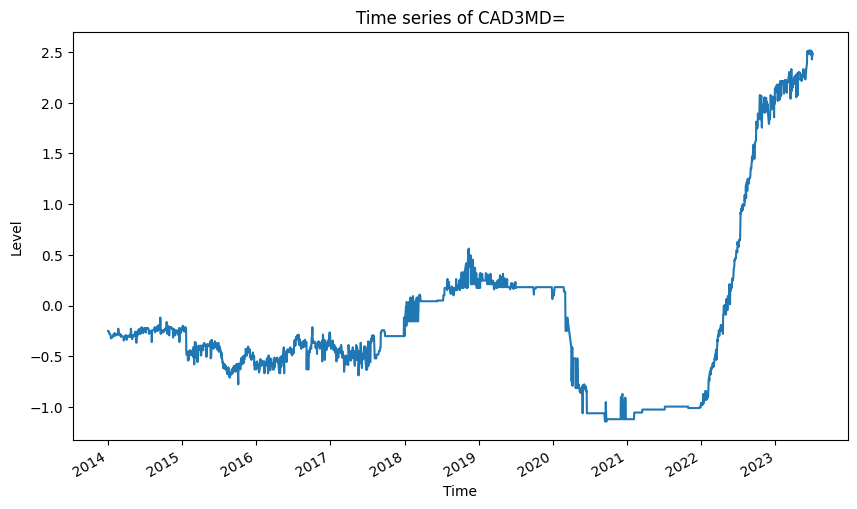

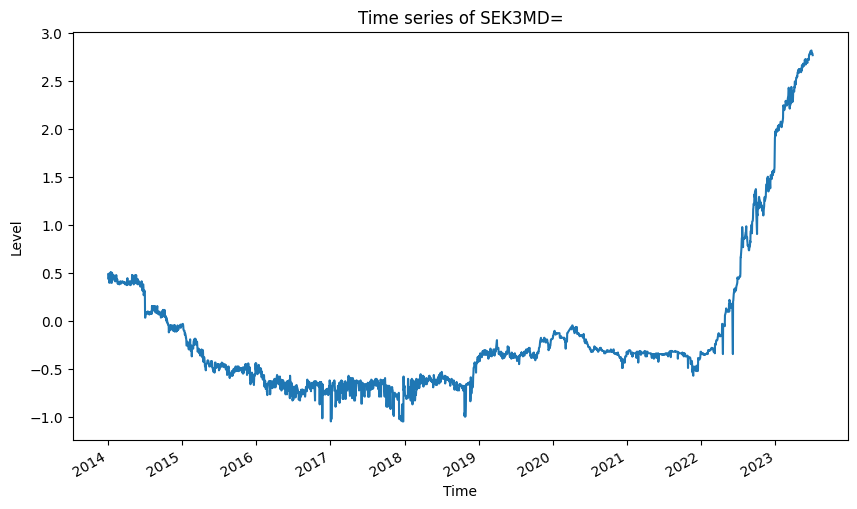

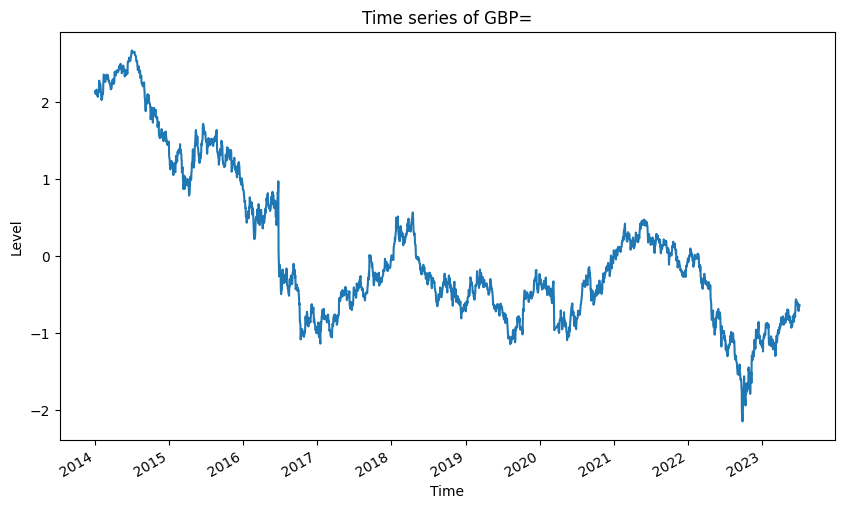

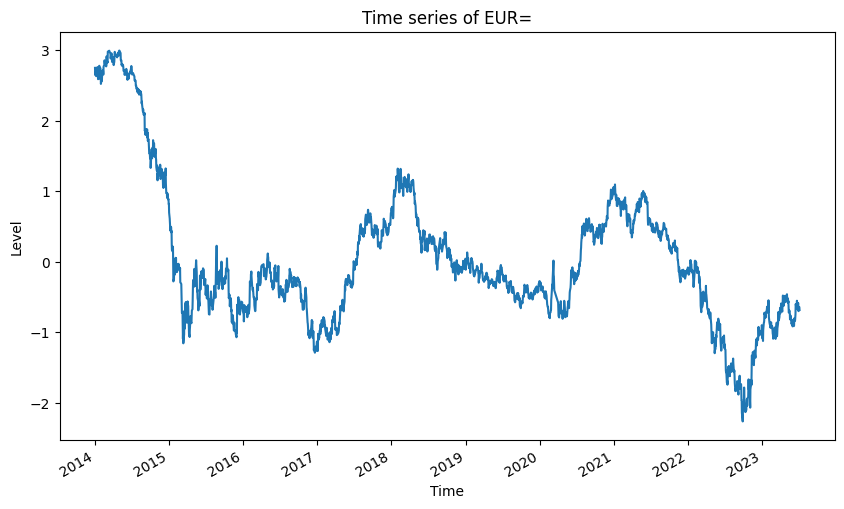

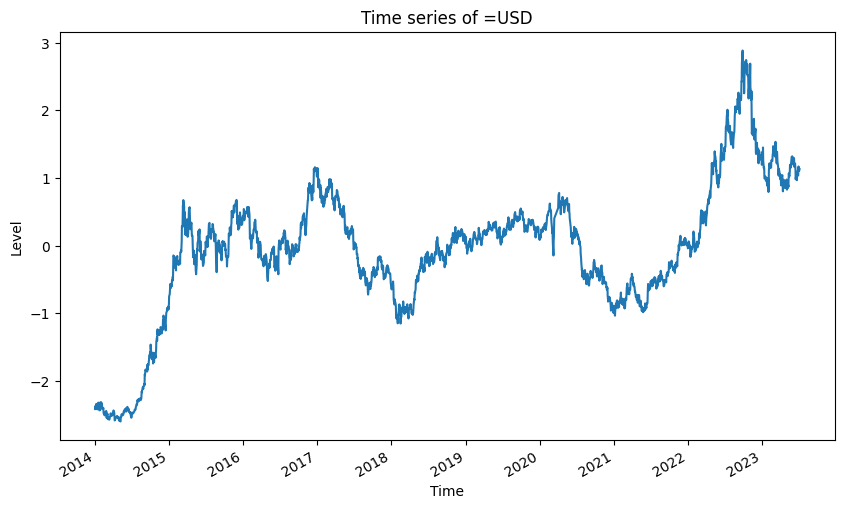

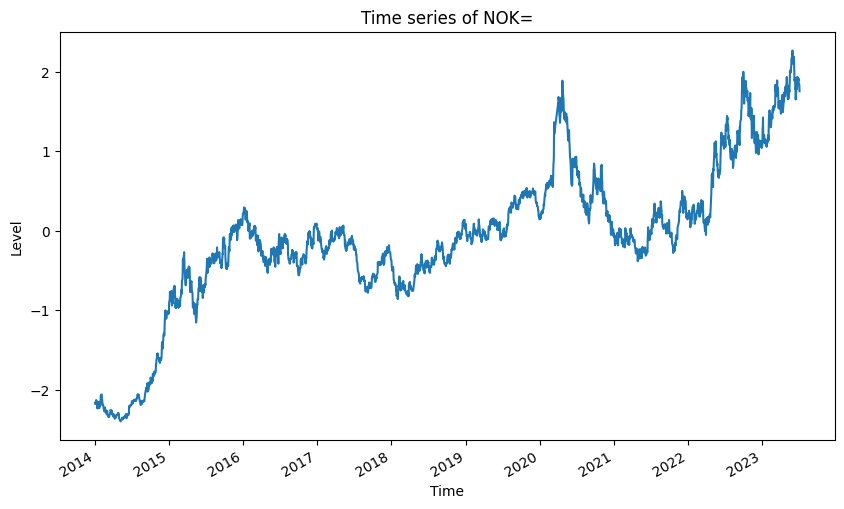

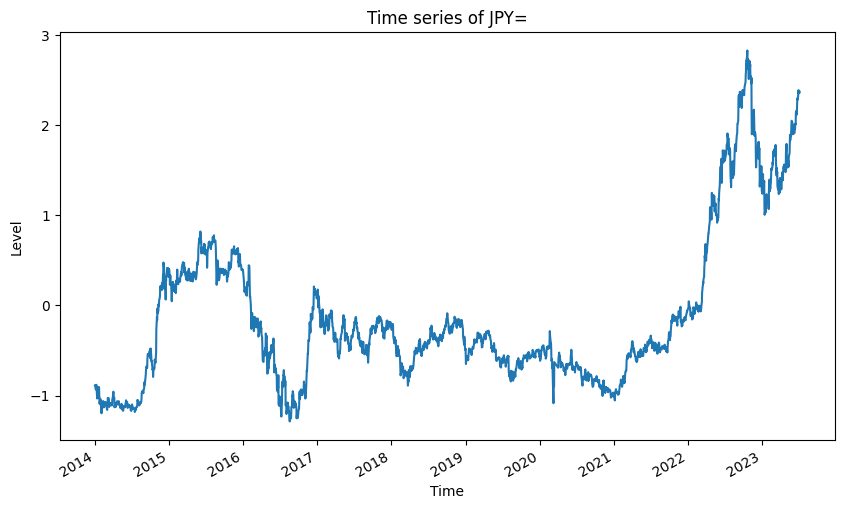

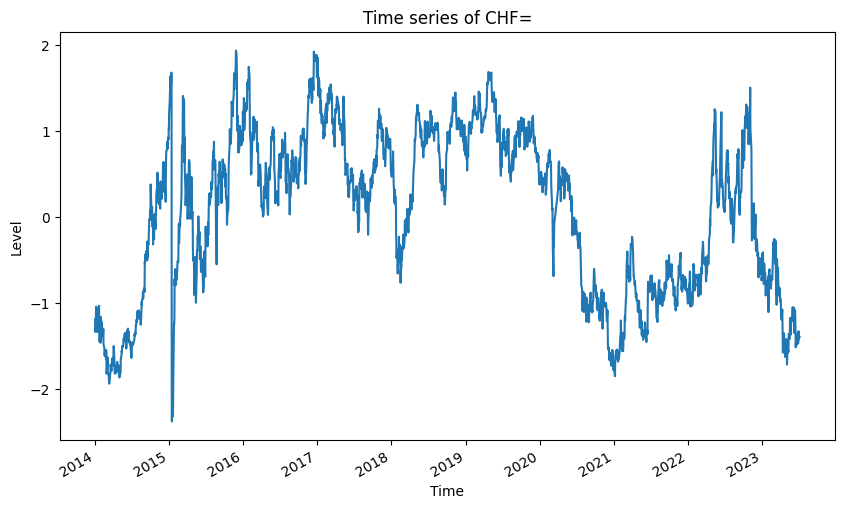

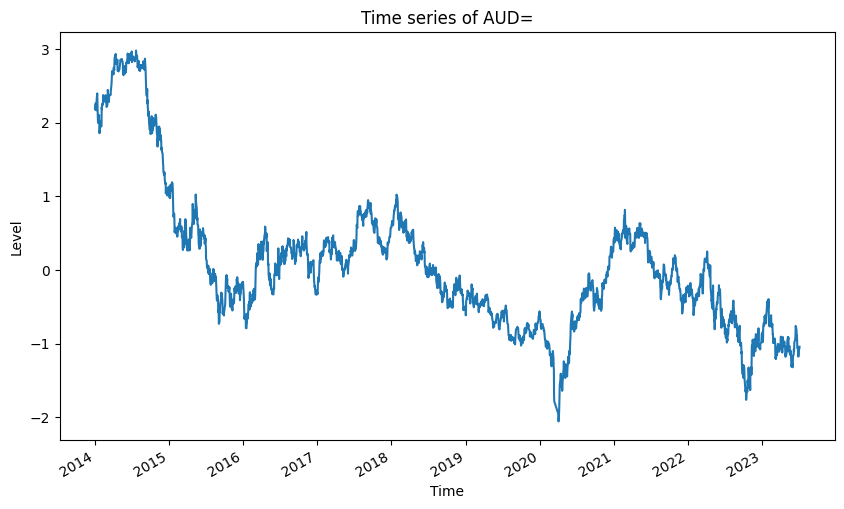

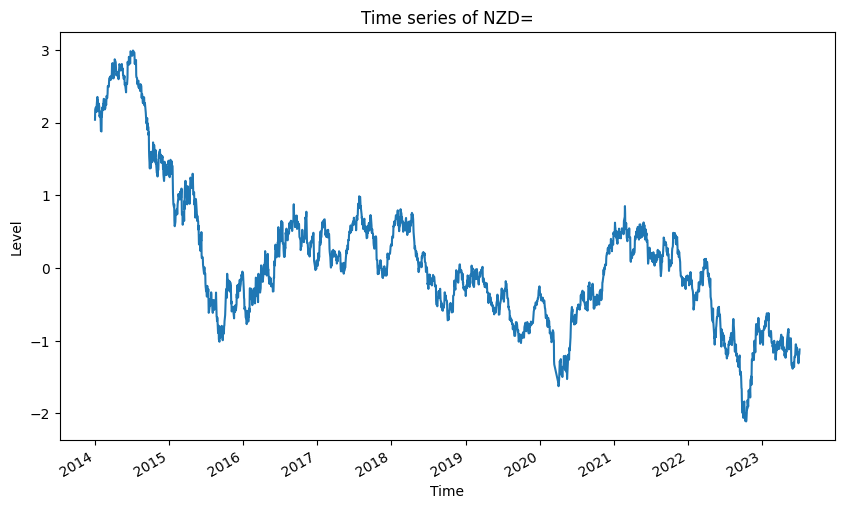

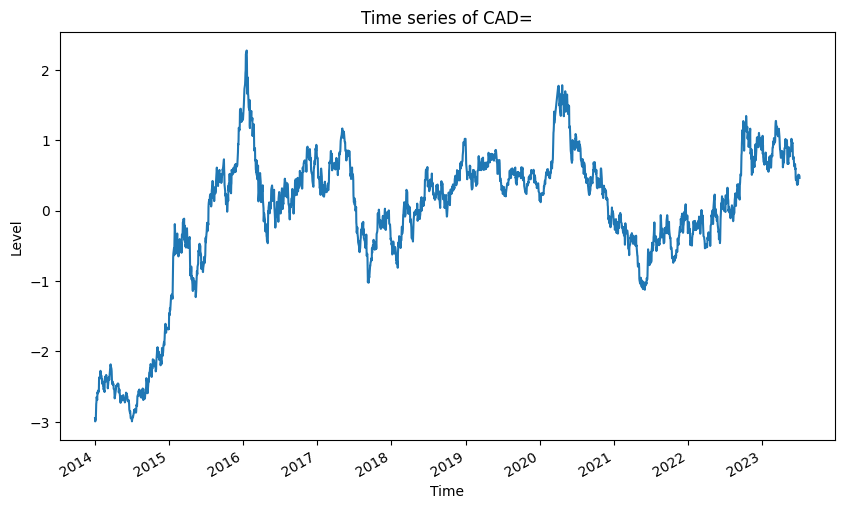

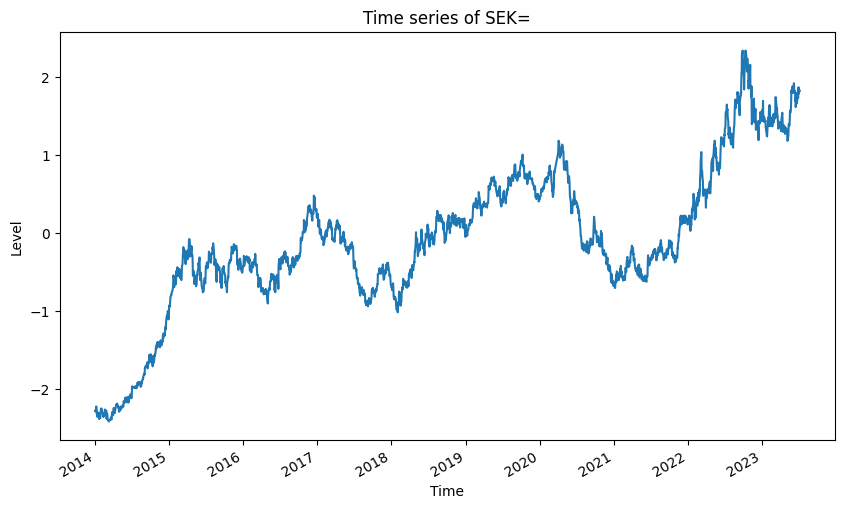

In [58]:
for column in df_variables_zscore:
    
    plt.figure(figsize=(10, 6))
    df_variables_zscore[column].plot(title=f"Time series of {column}")
    plt.title(f"Time series of {column}")
    plt.xlabel("Time")
    plt.ylabel("Level")
    plt.show()

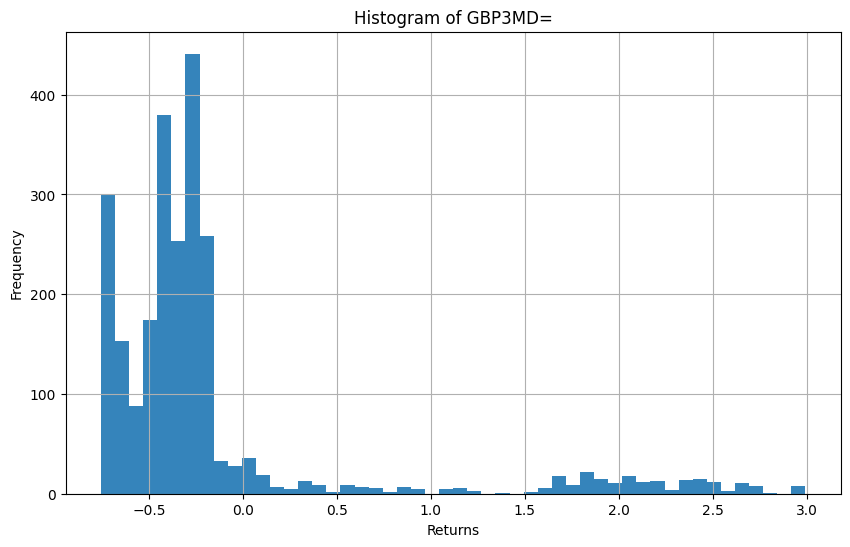

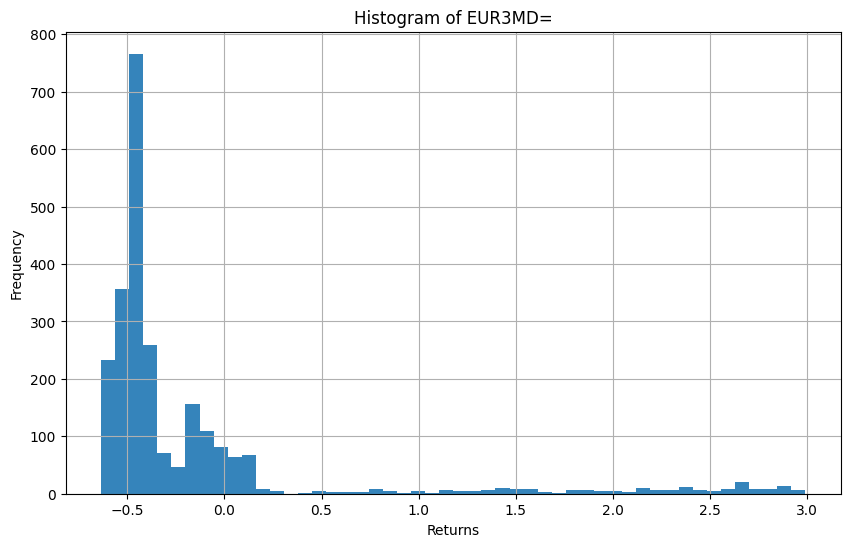

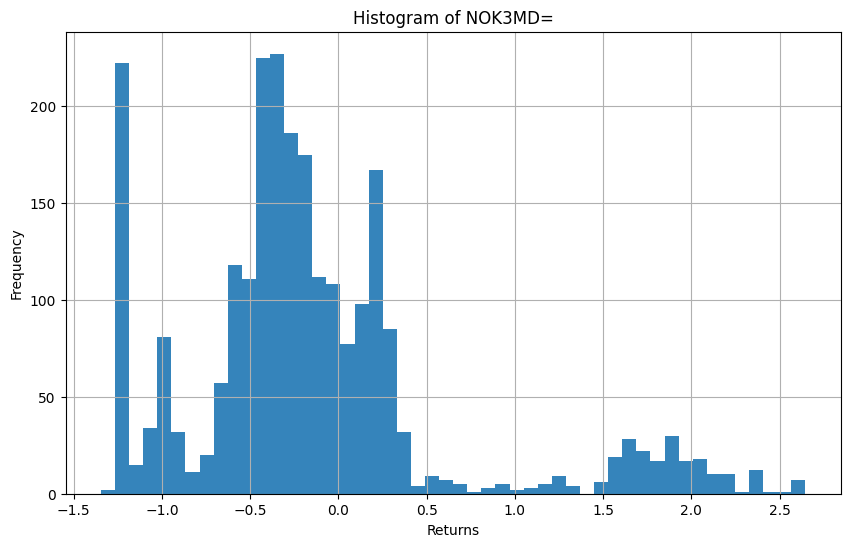

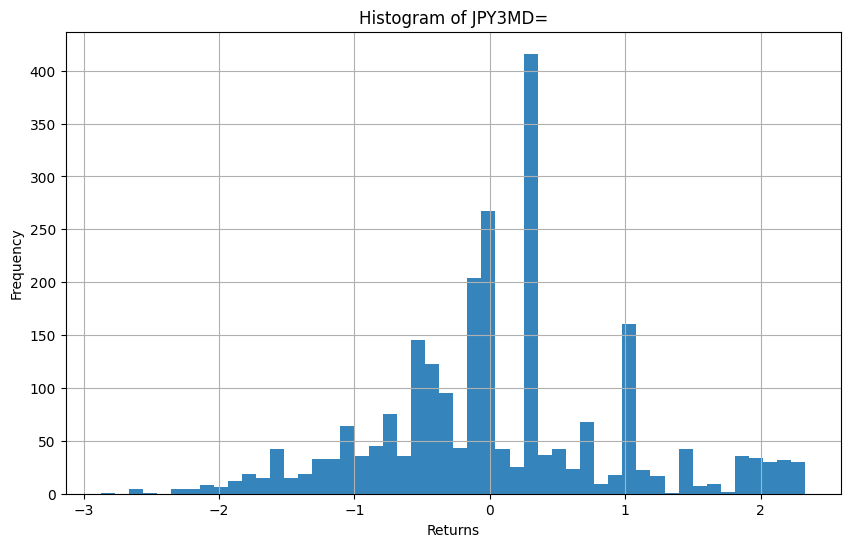

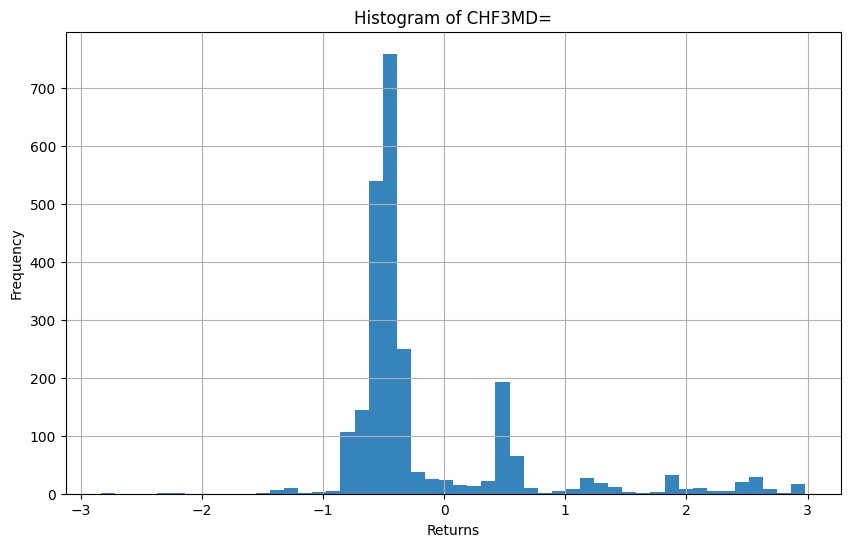

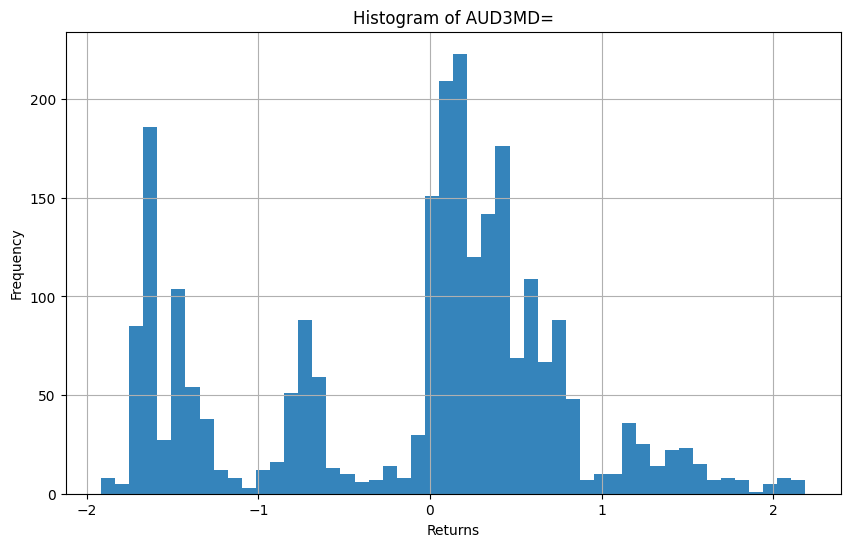

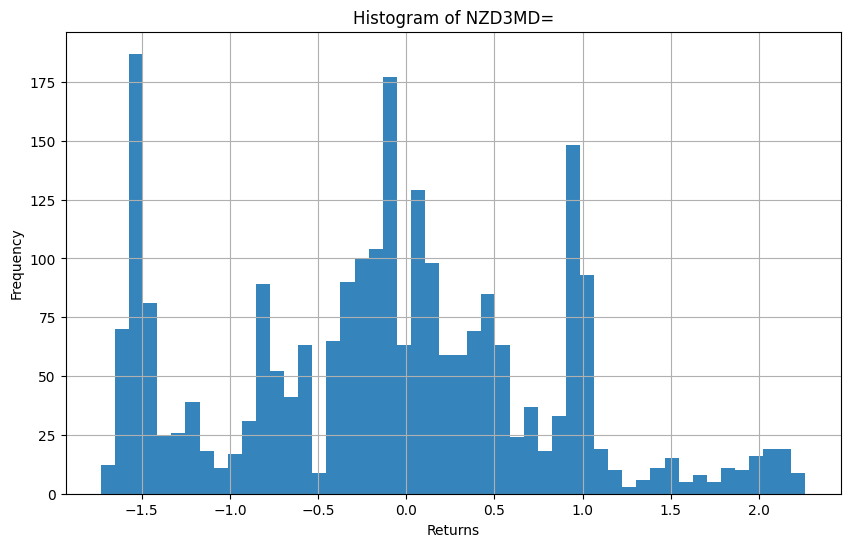

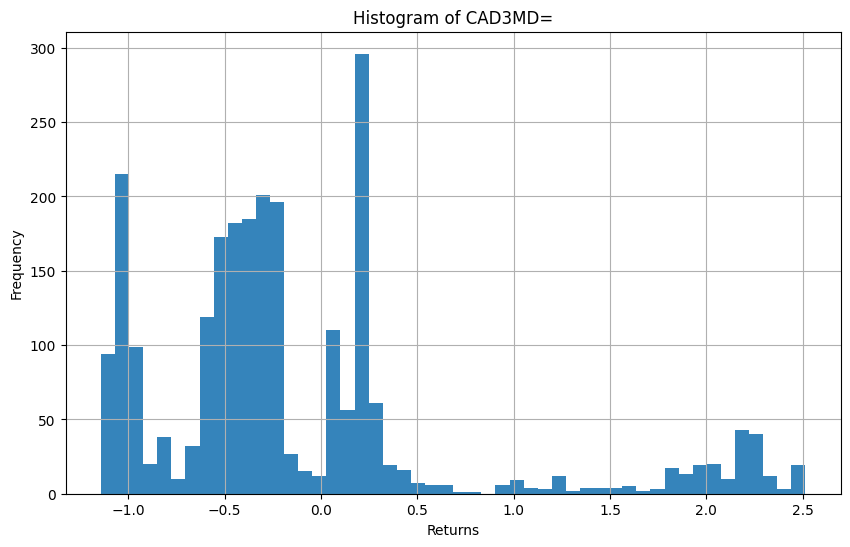

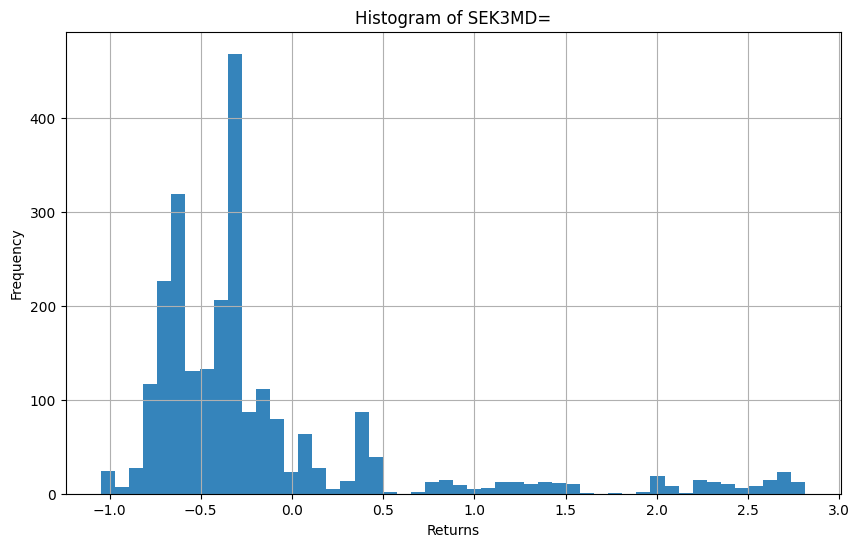

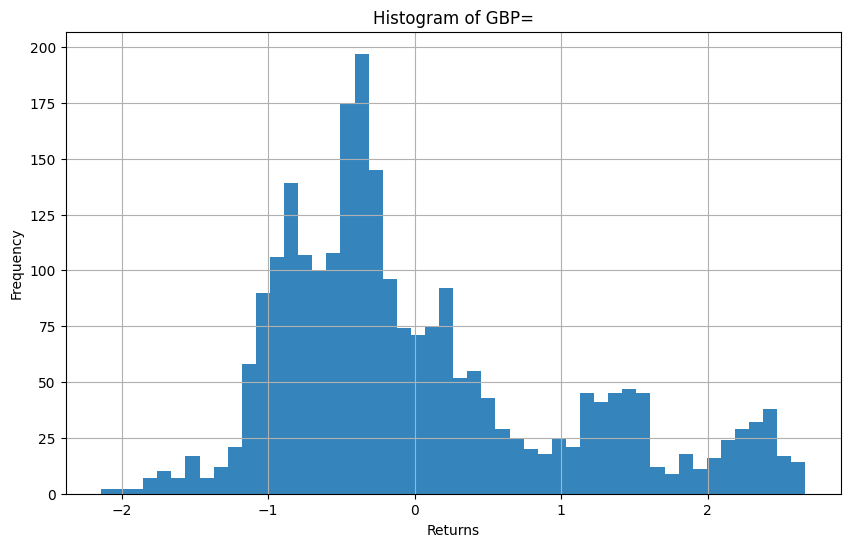

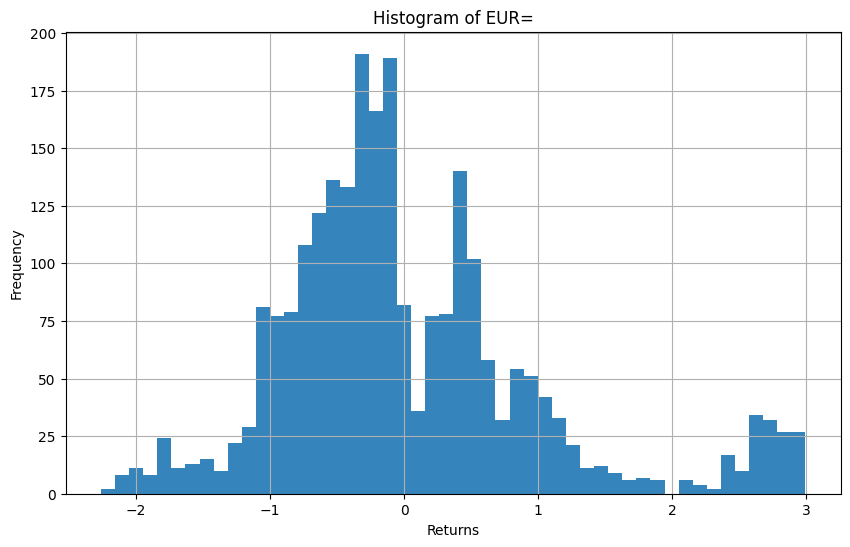

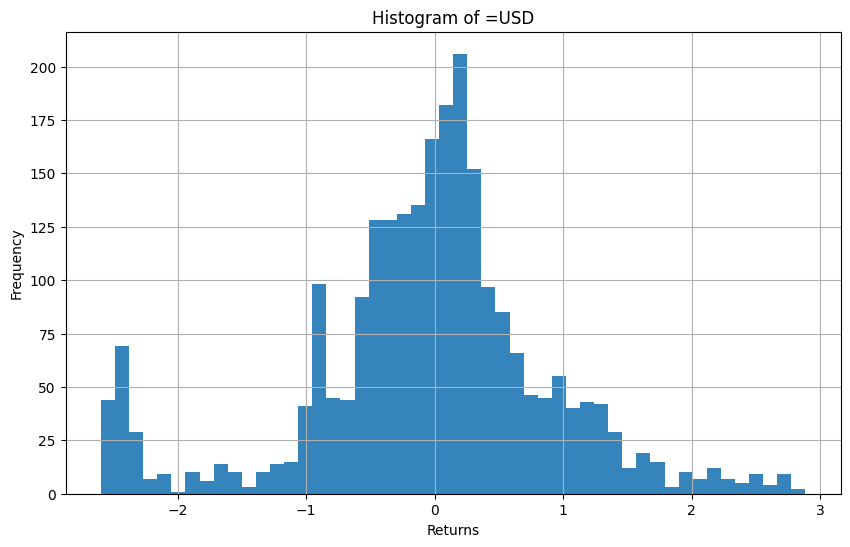

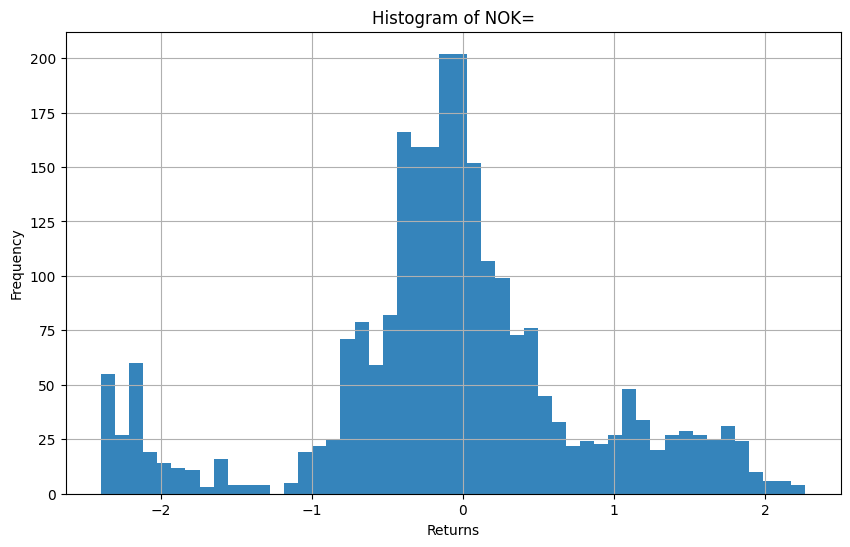

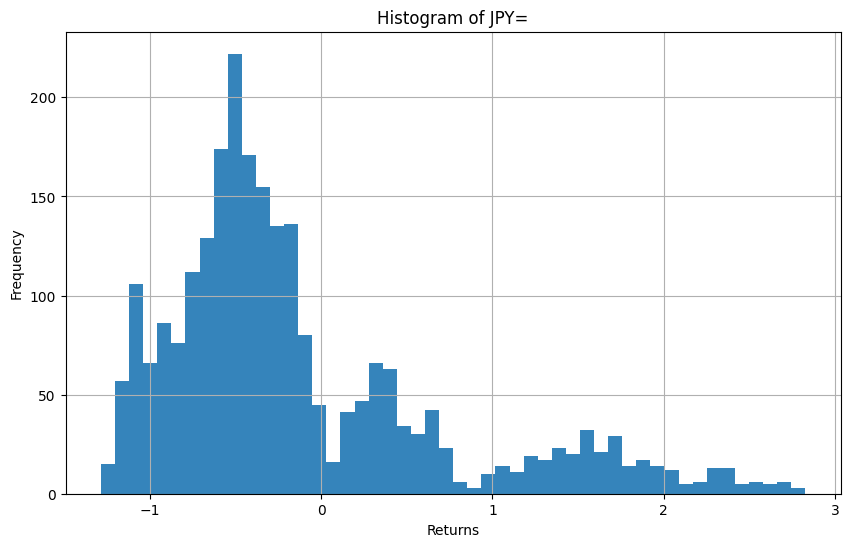

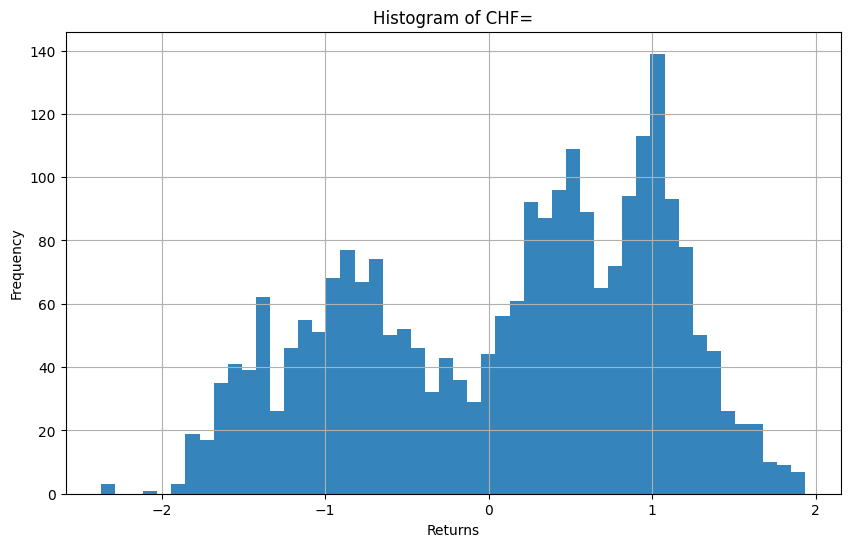

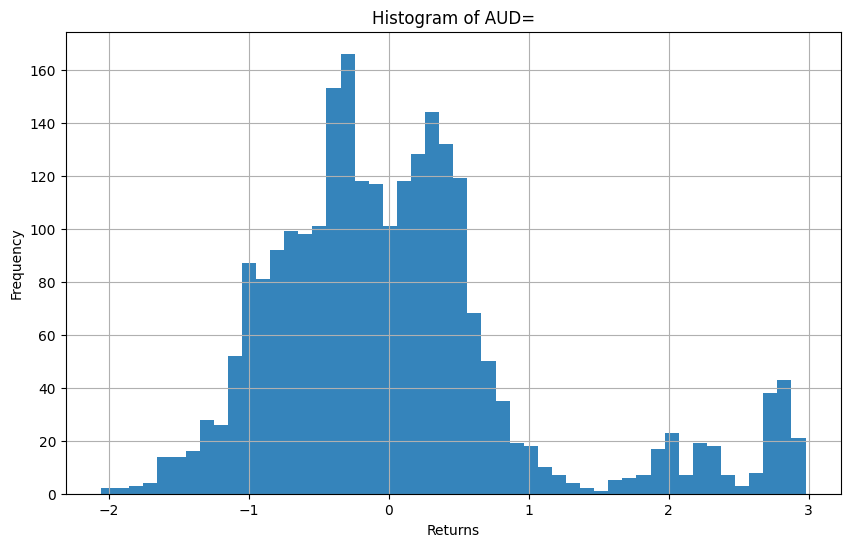

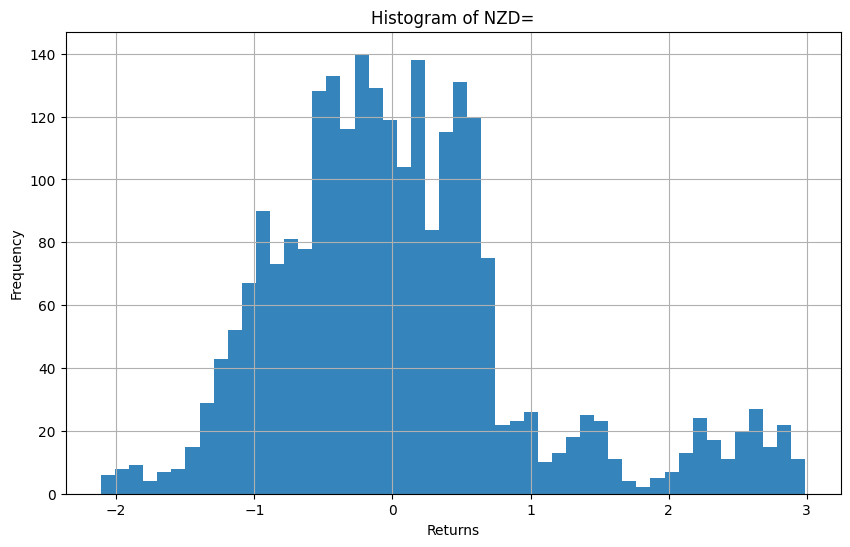

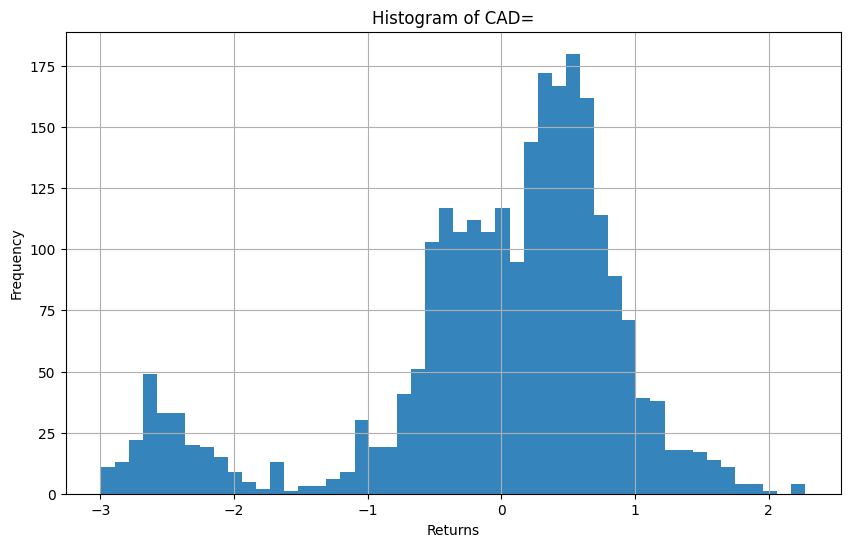

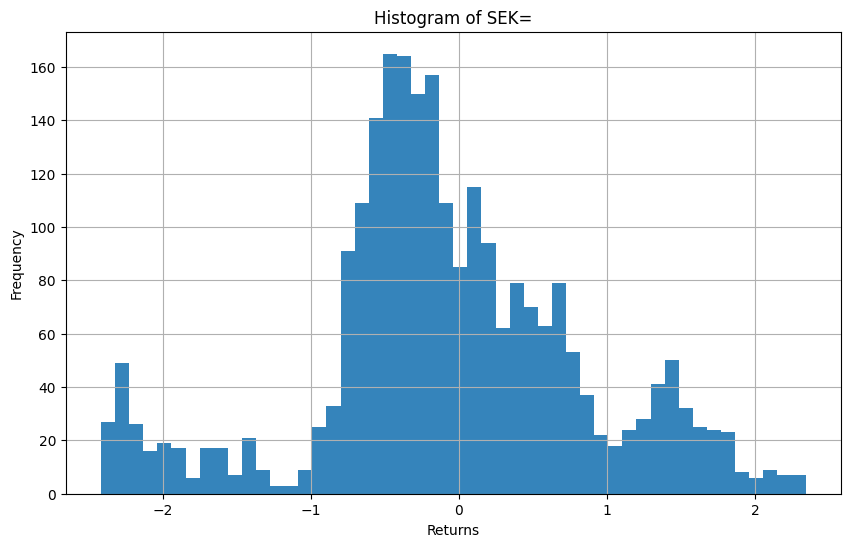

In [59]:
for column in df_variables_zscore:
    
    plt.figure(figsize=(10, 6))
    df_variables_zscore[column].hist(bins=50, alpha=0.9)
    plt.title(f"Histogram of {column}")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.show()

In [60]:
# Scaling of the dataset to better handle the modeling of the machine learning programs
#Change the y_xxx depending on which variable to assess (y_fx to train USD index forecasting and y_USD to train 3M US interest rate forecasting)

scaler = MinMaxScaler()
x = df_variables
y_fx = df_USDfx
y_USD = df_USD3M


# Split the dataset into training and testing sets without shuffling to preserve time series order (change either y_fx or y_USD)
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(df_variables, y_USD, train_size=0.7, shuffle=False)

# Convert the DataFrames to NumPy arrays for use in the neural network
X_train, X_test, Y_train, Y_test = X_train_df.to_numpy(), X_test_df.to_numpy(), Y_train_df.to_numpy(), Y_test_df.to_numpy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the training data
training_values = scaler.fit_transform(Y_train)

## **1. Implementation of MLP and LSTM models on 3-month US interest rate (USD3MD=) and USD (=USD) index data**

### 1.1 Deconstruction of the training sets

In [61]:
'''
#Data manipulation for the USD index
df_train_fx = df_USDfx[df_USDfx.index < Y_test_df.index[0]]
df_test_fx = df_USDfx[df_USDfx.index >= Y_test_df.index[0]]

train_fx = df_train_fx['=USD'].values
test_fx = df_test_fx['=USD'].values
'''

#Data manipulation for the 3M USD interest rate
df_train_USD3M = df_USD3M[df_USD3M.index < Y_test_df.index[0]]
df_test_USD3M = df_USD3M[df_USD3M.index >= Y_test_df.index[0]]

train_USD3M = df_train_USD3M['USD3MD='].values
test_USD3M = df_test_USD3M['USD3MD='].values


training_values = scaler.fit_transform(train_USD3M.reshape(-1, 1))

x_train = training_values[0:len(training_values)-1000]
y_train = training_values[1000:len(training_values)]

test_values = scaler.transform(test_USD3M.reshape(-1, 1))

#Adjust the script accordingly to match the model purpose (forecasting of USD index levels or 3M US interest rate)

### 1.2 Implementation of an MLP model

In [62]:
# MLP model structure

model_MLP_USD = Sequential()
model_MLP_USD.add(Dense(2048, activation='relu'))
model_MLP_USD.add(Dense(512, activation='relu'))
model_MLP_USD.add(Dense(128, activation='relu'))
model_MLP_USD.add(Dropout(0.25))
model_MLP_USD.add(Dense(32, activation='relu'))
model_MLP_USD.add(Dense(8, activation='relu'))
model_MLP_USD.add(Dense(4, activation='relu'))
model_MLP_USD.add(Dense(1))

In [63]:
# Parametrization of the MLP model (optimizer, loss type)

model_MLP_USD.compile(loss='mean_squared_error', optimizer='adam')

In [64]:
# Calibration of the MLP model parameters

model_MLP_USD.fit(x_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1449
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0464
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0448
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0439
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0425
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0387
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0370
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0450
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0409


In [65]:
# We perform a prediction of the model for the USD3MD= loading

price_MLP_USD = model_MLP_USD.predict(test_values)
price_MLP_USD = scaler.inverse_transform(price_MLP_USD)
price_MLP_USD = np.squeeze(price_MLP_USD.reshape(1,-1))
price_MLP_USD

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([ 2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,
        2.2919247 ,  2.2919247 ,  2.2919247 ,  2.2919247 ,  2.29

### 1.3 Implementation of the LSTM model

In [66]:
#Implementation of LSTM model

model_LSTM_USD = Sequential()
model_LSTM_USD.add(LSTM(128, return_sequences=True, input_shape=(None,1)))
model_LSTM_USD.add(LSTM(64, return_sequences=False))
model_LSTM_USD.add(Dropout(0.25))
model_LSTM_USD.add(Dense(25, activation='relu'))
model_LSTM_USD.add(Dense(1))

/opt/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
# We arrange the parameters (optimizer, loss)
model_LSTM_USD.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
# Calibration of LSTM
model_LSTM_USD.fit(x_train, y_train,epochs=10, batch_size=16)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2595
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1135
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0792
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0503
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429


In [69]:
# Predictions for LSTM

price_LSTM_USD = model_LSTM_USD.predict(test_values)
price_LSTM_USD = scaler.inverse_transform(price_LSTM_USD)
price_LSTM_USD = np.squeeze(price_LSTM_USD)
price_LSTM_USD

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([ 2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,
        2.5256038 ,  2.5256038 ,  2.5256038 ,  2.5256038 ,  2.52

In [70]:
# Ensure Y_test is 1-dimensional
Y_test = Y_test.reshape(-1)

# Ensure predictions are 1-dimensional
price_MLP_USD = np.squeeze(price_MLP_USD)
price_LSTM_USD = np.squeeze(price_LSTM_USD)

# Results of the implemented models in a dataframe
results_USD_prediction = pd.DataFrame({
    'Real_price_USD': Y_test,
    'Pred_MLP_USD': price_MLP_USD,
    'Pred_LSTM_USD': price_LSTM_USD
})

<Axes: >

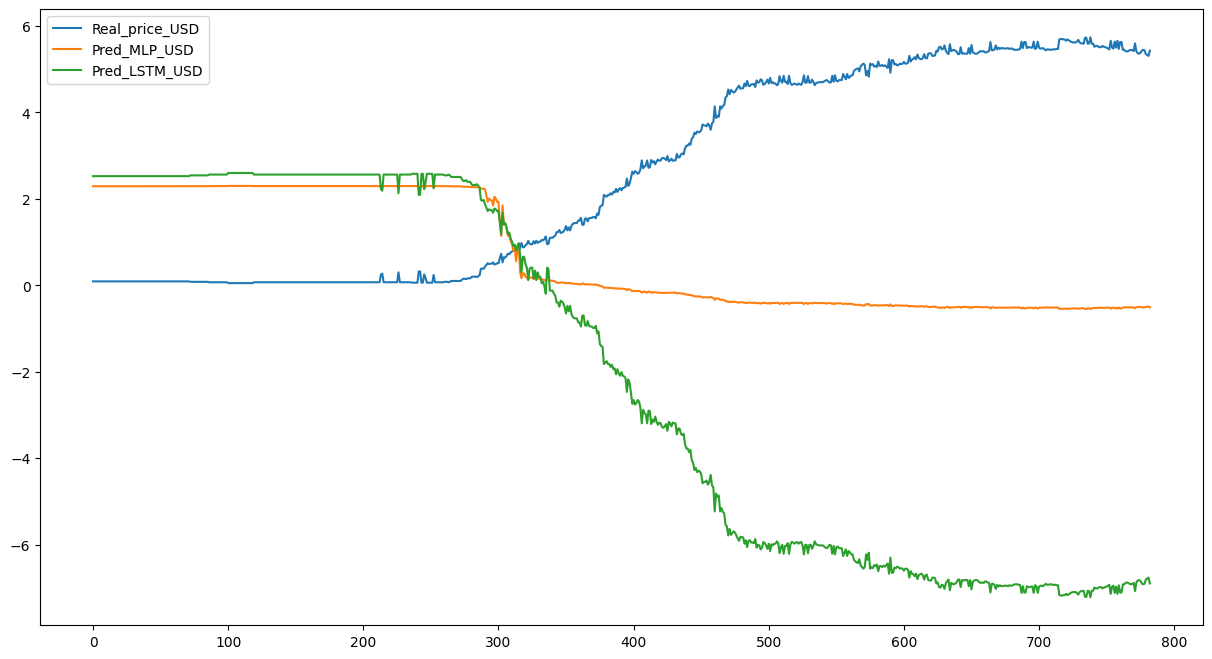

In [71]:
# Plotting the predictions against actual USD3MD= prices for MLP and LSTM

results_USD_prediction['Real_price_USD'].plot(legend='Real level of USD3MD=', figsize=(15,8))
results_USD_prediction['Pred_MLP_USD'].plot(legend='Forecast MLP')
results_USD_prediction['Pred_LSTM_USD'].plot(legend='Forecast LSTM')

In [72]:
# Computation of the mean absolut error (MAE):

MAE_pred_MLP_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MAE_pred_LSTM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
print("MAE for the forecasted MLP model:", MAE_pred_MLP_USD)
print("MAE for the forecasted LSTM model:", MAE_pred_LSTM_USD)

# Computation of the mean squared error (MSE):

MSE_pred_MLP_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MSE_pred_LSTM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
print("MSE obtained for the forecasted MLP model:", MSE_pred_MLP_USD)
print("MSE for the forecasted LSTM model:", MSE_pred_LSTM_USD)

# Computation of the root mean squared error (RMSE):

RMSE_pred_MLP_USD = np.sqrt(MSE_pred_MLP_USD)
RMSE_pred_LSTM_USD = np.sqrt(MSE_pred_LSTM_USD)
print("RMSE obtained for the forecasted MLP model:", RMSE_pred_MLP_USD)
print("RMSE for the forecasted LSTM model:", RMSE_pred_LSTM_USD)

MAE for the forecasted MLP model: 3.5785581859533275
MAE for the forecasted LSTM model: 6.521942518538348
MSE obtained for the forecasted MLP model: 16.11304962881667
MSE for the forecasted LSTM model: 63.46879355329885
RMSE obtained for the forecasted MLP model: 4.014106330033706
RMSE for the forecasted LSTM model: 7.96673041801333


# **2. Implementation of alternative machine learning models**

### 2.1 SVM application

Suport Vector Machine (SVM) is a non-parametric machine learning technique that uses the concept of Support Vector Regression (SVR) to address regression problems. The C parameter is set to 1.0, controlling the trade-off between the model's complexity (and accuracy on training data) and the degree to which it generalizes.

In [73]:
# Creation of the SVM model characteristics

model_SVM = SVR(kernel='rbf', C=1.0, gamma='scale')

In [74]:
# Calibration of the random forest model

model_SVM.fit(X_train, Y_train)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [75]:
# Analysis of the price forecasting using the SVM

price_SVM = model_SVM.predict(X_test)
price_SVM

array([ 0.82630058,  0.84442085,  0.82722556,  0.81381627,  0.79810847,
        0.80431163,  0.81724991,  0.83297004,  0.82135475,  0.83540128,
        0.83564591,  0.86029685,  0.86523382,  0.83968078,  0.8462524 ,
        0.82961377,  0.83257715,  0.83514829,  0.83224468,  0.84498326,
        0.83382639,  0.82643905,  0.84204658,  0.84235532,  0.84246818,
        0.85339304,  0.83441039,  0.83661642,  0.82446881,  0.82540597,
        0.82078782,  0.81592149,  0.79876682,  0.79954062,  0.81543083,
        0.80161406,  0.79360169,  0.78760748,  0.78879066,  0.76806092,
        0.77018735,  0.79949806,  0.79910918,  0.79043336,  0.79620416,
        0.80097437,  0.80636885,  0.81251009,  0.80241633,  0.79464898,
        0.76740392,  0.76855045,  0.77299753,  0.78065089,  0.76023046,
        0.78613223,  0.79215172,  0.78444324,  0.82040307,  0.82879675,
        0.82931836,  0.81089668,  0.81450168,  0.81879199,  0.80457344,
        0.79136276,  0.79696124,  0.79284367,  0.78473204,  0.78

### 2.2 Random Forest application

Random Forest (RF) is a machine learning technique that works by building many decision trees during training and then showing the average forecast of all the trees. When using individual decision trees, especially for regression tasks, the risk of overfitting is higher. The ensemble method lowers this risk. In our project, it is created with 50 trees (n\_estimators) in the forest. The random\_state ensures that the results are reproducible.

In [76]:
# Creation of the RF model characteristics

model_rdmforest = RandomForestRegressor(n_estimators=50, random_state=42)

In [77]:
# Calibration of the random forest model

model_rdmforest.fit(X_train, Y_train)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
# Analysis of the price forecasting using the random forest

price_rdmforest = model_rdmforest.predict(X_test)
price_rdmforest

array([0.09  , 0.09  , 0.0904, 0.0902, 0.0904, 0.0902, 0.0894, 0.0912,
       0.0922, 0.092 , 0.0922, 0.085 , 0.0878, 0.0876, 0.088 , 0.0898,
       0.0898, 0.0878, 0.0898, 0.0854, 0.0872, 0.0874, 0.0872, 0.0872,
       0.0872, 0.0882, 0.0904, 0.0878, 0.0912, 0.0918, 0.0912, 0.0912,
       0.0922, 0.098 , 0.0986, 0.0944, 0.0926, 0.0936, 0.0934, 0.099 ,
       0.0978, 0.097 , 0.0986, 0.0978, 0.098 , 0.096 , 0.0982, 0.0964,
       0.0966, 0.0956, 0.0966, 0.0978, 0.0962, 0.0976, 0.0976, 0.0976,
       0.0974, 0.0976, 0.096 , 0.096 , 0.096 , 0.0976, 0.0978, 0.098 ,
       0.0974, 0.098 , 0.0992, 0.0976, 0.0964, 0.0964, 0.0962, 0.0978,
       0.0966, 0.0962, 0.0962, 0.0962, 0.0972, 0.0962, 0.0962, 0.0962,
       0.0962, 0.0974, 0.0962, 0.0964, 0.0966, 0.0964, 0.0974, 0.0958,
       0.0958, 0.0962, 0.0972, 0.0986, 0.097 , 0.0974, 0.0962, 0.0966,
       0.0982, 0.0988, 0.099 , 0.098 , 0.098 , 0.0986, 0.0966, 0.098 ,
       0.098 , 0.098 , 0.0986, 0.098 , 0.0986, 0.0986, 0.097 , 0.0986,
      

### 2.3 Gradient Boosting

Gradient Boosting (GB) creates an additive model one step at a time, and it can be used to improve any differentiable loss function. It is done by fitting a regression tree to the negative gradient of the given loss function at each stage. This lowers the residuals of the earlier models. The boosting method focuses on areas where the old models don't do well by adding weak learners one at a time. In our project, the model uses 50 trees with a learning rate of 0.1 and a maximum depth of 3 for each tree.

In [79]:
model_gboosting = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

In [80]:
# Calibration of the gradient boosting model
model_gboosting.fit(X_train, Y_train)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,50
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [81]:
# Analysis of the price forecasting using the gradient boosting
price_gboosting = model_gboosting.predict(X_test)
price_gboosting

array([0.08696406, 0.08696406, 0.08696406, 0.105265  , 0.1000126 ,
       0.1000126 , 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.09221646,
       0.09221646, 0.09221646, 0.09221646, 0.09221646, 0.09221646,
       0.09221646, 0.09221646, 0.09221646, 0.09221646, 0.09221646,
       0.09221646, 0.105265  , 0.1000126 , 0.105265  , 0.105265  ,
       0.105265  , 0.09221646, 0.105265  , 0.105265  , 0.09221646,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231

### 2.4 Consolidation of the estimations of the 3-month US interest rate and comparison of the predictions

In [82]:
results_prediction_alternative = pd.DataFrame({'Pred_SVM': price_SVM , 'Pred_gboosting': price_gboosting, 'Pred_rdmforest': price_rdmforest})
results_prediction_alternative.head(n=5)
results_prediction_alternative.head(n=5)

,Pred_SVM,Pred_gboosting,Pred_rdmforest
0,0.826301,0.086964,0.0900
1,0.844421,0.086964,0.0900
2,0.827226,0.086964,0.0904
3,0.813816,0.105265,0.0902
4,0.798108,0.100013,0.0904


<Axes: >

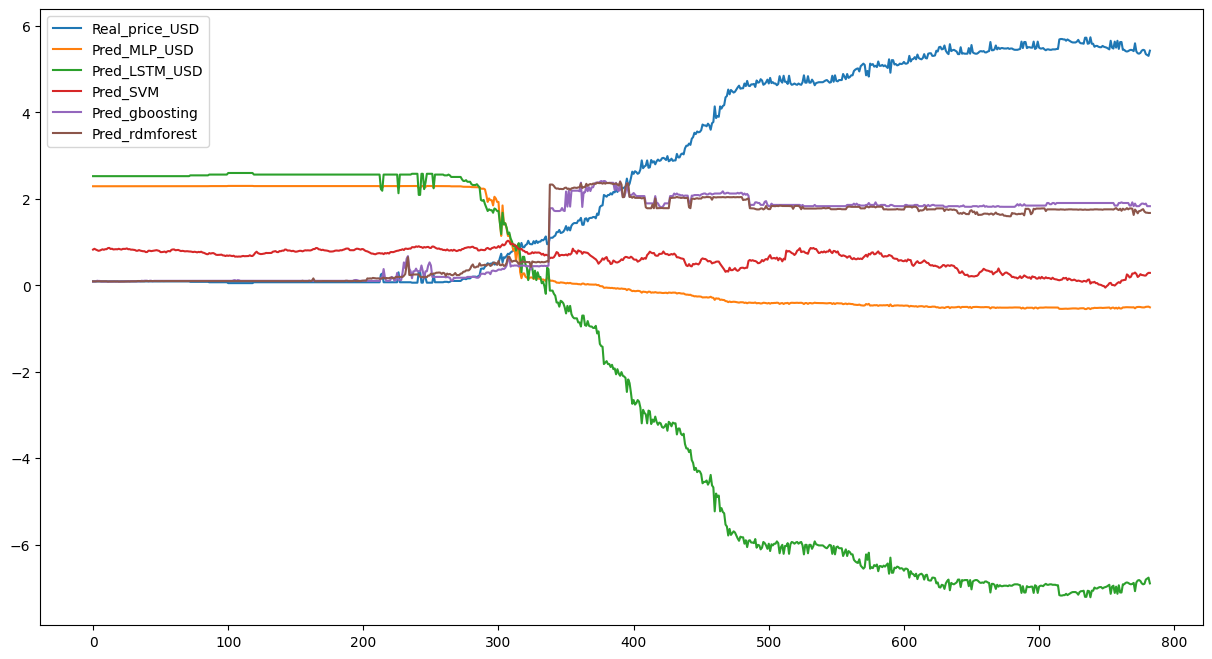

In [83]:
# Plot the consolidated forecasting results against the benchmark 3MUSD= index

results_USD_prediction['Real_price_USD'].plot(legend='Real level of USD3MD=', figsize=(15,8))
results_USD_prediction['Pred_MLP_USD'].plot(legend='Forecast MLP')
results_USD_prediction['Pred_LSTM_USD'].plot(legend='Forecast LSTM')
results_prediction_alternative['Pred_SVM'].plot(legend='Forecast SVM')
results_prediction_alternative['Pred_gboosting'].plot(legend='Forecast XGBoost')
results_prediction_alternative['Pred_rdmforest'].plot(legend='Forecast Random Forest')

In [84]:
# Computation of the mean absolut error (MAE):

MAE_pred_MLP_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MAE_pred_LSTM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
MAE_pred_SVM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_SVM'])
MAE_pred_gboosting_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_gboosting'])
MAE_pred_rdmforest_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_rdmforest'])

print("MAE obtained for the forecasted MLP model:", MAE_pred_MLP_USD)
print("MAE obtained for the forecasted LSTM model:", MAE_pred_LSTM_USD)
print("MAE obtained for the forecasted SVM model:", MAE_pred_SVM_USD)
print("MAE obtained for the forecasted Gradient Boosting model:", MAE_pred_gboosting_USD)
print("MAE obtained for the forecasted Random Forest model:", MAE_pred_rdmforest_USD)

# Computation of the mean squared error (MSE):

MSE_pred_MLP_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MSE_pred_LSTM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
MSE_pred_SVM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_SVM'])
MSE_pred_gboosting_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_gboosting'])
MSE_pred_rdmforest_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_rdmforest'])

print("MSE obtained for the forecasted MLP model:", MSE_pred_MLP_USD)
print("MSE obtained for the forecasted LSTM model:", MSE_pred_LSTM_USD)
print("MSE obtained for the forecasted SVM model:", MSE_pred_SVM_USD)
print("MSE obtained for the forecasted Gradient Boosting model:", MSE_pred_gboosting_USD)
print("MSE obtained for the forecasted Random Forest model:", MSE_pred_rdmforest_USD)

# Computation of the root mean squared error (RMSE):

RMSE_pred_MLP_USD = np.sqrt(MSE_pred_MLP_USD)
RMSE_pred_LSTM_USD = np.sqrt(MSE_pred_LSTM_USD)
RMSE_pred_SVM_USD = np.sqrt(MSE_pred_SVM_USD)
RMSE_pred_gboosting_USD = np.sqrt(MSE_pred_gboosting_USD)
RMSE_pred_rdmforest_USD = np.sqrt(MSE_pred_rdmforest_USD)
print("RMSE obtained for the forecasted MLP model:", RMSE_pred_MLP_USD)
print("RMSE obtained for the forecasted LSTM model:", RMSE_pred_LSTM_USD)
print("RMSE obtained for the forecasted SVM model:", RMSE_pred_SVM_USD)
print("RMSE obtained for the forecasted Gradient Boosting model:", RMSE_pred_gboosting_USD)
print("RMSE obtained for the forecasted Random Forest model:", RMSE_pred_rdmforest_USD)

MAE obtained for the forecasted MLP model: 3.5785581859533275
MAE obtained for the forecasted LSTM model: 6.521942518538348
MAE obtained for the forecasted SVM model: 2.505437568552426
MAE obtained for the forecasted Gradient Boosting model: 1.5175471813215036
MAE obtained for the forecasted Random Forest model: 1.5734017879948914
MSE obtained for the forecasted MLP model: 16.11304962881667
MSE obtained for the forecasted LSTM model: 63.46879355329885
MSE obtained for the forecasted SVM model: 10.198833469746921
MSE obtained for the forecasted Gradient Boosting model: 4.650260442609346
MSE obtained for the forecasted Random Forest model: 4.974782181149427
RMSE obtained for the forecasted MLP model: 4.014106330033706
RMSE obtained for the forecasted LSTM model: 7.96673041801333
RMSE obtained for the forecasted SVM model: 3.193561251917195
RMSE obtained for the forecasted Gradient Boosting model: 2.1564462531232595
RMSE obtained for the forecasted Random Forest model: 2.2304219737864464
